# Gram continuation algorithm

This notebook implements the Gram-Fourier continuation algorithm (first developed by Lyon and Bruno (https://doi.org/10.1016/j.jcp.2009.11.020, https://doi.org/10.1016/j.jcp.2010.01.006) to compute extension and interpolation tables.

It notebook uses the arbitrary floating point precision library mpmath and implements the Gram-Schmidt orthogonalisation algorithm and computes the left and right orthogonal polynomial basis. It then uses the mpmath's SVD algorithm to compute accurate continuations of the Gram polynomials. Finally, it computes matrices that compute the forward and backward FFTs in high precision. The results of all these computations are stored in binary files in double precision. 

Furthermore, the notebook can create header files with the extension and interpolation tables. 

Notice that many of these computations take a long time and recreating all the tables provided by default may take a week of CPU time. 

In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from mpmath import *

mp.dps = 64

# Implement the Gram Schmidt orthogonalisation algorithm using mpmath 
class GramSchmidt:
    def __init__(self, x, m):
        self.x = x 
        self.m = m 
        self.A = mp.zeros(m, len(x))
        #Linear map for polynomial scalar product
        for i in range(m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                self.A[i, j] = x[j]**i

        #Write basis vector as columns of matrix V
        self.V = mp.eye(m)

        self.U = self.modifiedGramSchmidt(self.V) 

    def evaluateBasis(self, x, basis_element): 
        #Linear map for polynomial scalar product
        A = mp.zeros(self.m, len(x))
        for i in range(self.m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                A[i, j] = x[j]**i
        ei = self.U[:, basis_element].T * A 
        
        return ei
    
    def sp(self, u, v):
        return mp.fsum((u.T * self.A) * (v.T * self.A).T)

    def proj(self, u, v):
        a1 = self.sp(v, u) 
        a2 = self.sp(u, u)
        return a1/a2 * u 

    def norm(self, u):
        return mp.sqrt(self.sp(u, u))

    def modifiedGramSchmidt(self, V): 
        n, k = V.rows, V.cols
        U    = V.copy()
        U[:, 0] = V[:, 0] / self.norm(V[:, 0]) 

        for i in range(1, k): 
            for j in range(i, k): 
                U[:, j] = U[:, j] - self.proj(U[:, i - 1], U[:, j])


            U[:, i] = U[:, i] / self.norm(U[:, i])
        return U

    def projectFunction(self, f): 
        coeffs = mp.matrix(1, self.m) 

        for i in range(self.m): 
            basis = (self.U[:, i].T * self.A)
            coeffs[0, i] = mp.fsum(f * basis.T)


        return coeffs
    
    def reconstructFunction(self, coeffs, x = None): 
        if x == None:
            A = self.A
        else: 
            A = mp.zeros(self.m, len(x))
            for i in range(self.m): 
                for j in range(len(x)): 
                    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                    self.A[i] = x[j]**i
            
        frec = mp.matrix(1, A.cols)
        for i in range(self.m): 
            frec += coeffs[0, i] * (self.U[:, i].T * A)
        return frec 
    
    def debug(self):
        m = self.m 
        u_ij = mp.zeros(m) 

        plt.title(f"Unorthogonalised polynomials m = {m}")
        for i in range(m):
            plt.plot(self.x, self.V[:, i].T * self.A, label=f"x^{i}")
        plt.legend()
        plt.show()



        plt.title(f"Orthonormalised polynomials m = {m}")
        for i in range(m):
            plt.plot(self.x, self.U[:, i].T * self.A, label=f"{i}")
        plt.legend()
        plt.show()

        print("The orthonormalised polynomials and their scalar products")
        for i in range(m):
            for j in range(m):
                u_ij[i, j] = self.sp(self.U[:, i], self.U[:, j])
            print(f"i = {i} u_ij = {u_ij[i, :]}")

class SVDFourierExtension:
    # Implement the SVD Fourier continuation algorithm using mpmath 
    M_ALL_K  = 0 
    M_EVEN_K = 1
    M_ODD_K  = 2 

    def __init__(self, m, nDelta, nd, Gamma, g): 
        self.m      = m 
        self.nDelta = nDelta
        self.nd     = nd 
        self.Gamma  = Gamma 
        self.g      = g 
        # Set up evaluation grid 
        self.h      = mp.mpf(1)/mp.mpf(nd - 1) 
        self.d      = mp.mpf(nd - 1) * self.h 
        self.Delta  = mp.mpf(nDelta  - 1) * self.h 

        x = mp.linspace(0, 1, nd)

        # Compute left and right Gram Schmidt extensions 
        leftBoundary  = x[       :nDelta]
        rightBoundary = x[-nDelta:      ]

        self.lgs = GramSchmidt(leftBoundary, m)
        self.rgs = GramSchmidt(rightBoundary, m)

        dxeval = self.Delta/(Gamma - 1) 
        self.xeval  = mp.matrix(1, Gamma) 
        for i in range(Gamma): 
            self.xeval[0, i] = 1 - self.Delta + i * dxeval

        #Set up extension grid 
        self.xext  = mp.linspace(1 - self.Delta, 1 + self.Delta + 2*self.d, 1000) 
        mode  = self.M_EVEN_K
        M     = self.getM(g, Gamma, self.Delta, self.d, mode)
        Minv  = self.invertComplexM(M, 0)
        self.evencoeffs = []
        self.evenbasis  = []
        self.evenfrecs  = []
        for i in range(m): 
            yeval = self.rgs.evaluateBasis(self.xeval, i)
            a     = self.iterativeRefinement(M, Minv, yeval) 
            frec  = self.reconstruct(self.xext, a, g, Gamma, self.Delta, self.d, mode)
            self.evencoeffs.append(a) 
            self.evenbasis.append(yeval)
            self.evenfrecs.append(frec)


        mode  = self.M_ODD_K
        M     = self.getM(g, Gamma, self.Delta, self.d, mode)
        Minv  = self.invertComplexM(M, 0)
        self.oddcoeffs = []
        self.oddbasis = []
        self.oddfrecs = []
        for i in range(m): 
            yeval = self.rgs.evaluateBasis(self.xeval, i)
            a     = self.iterativeRefinement(M, Minv, yeval) 
            frec  = self.reconstruct(self.xext, a, g, Gamma, self.Delta, self.d, mode)
            self.oddcoeffs.append(a) 
            self.oddbasis.append(yeval)
            self.oddfrecs.append(frec)

        Next = 2 * nd + 2 * nDelta - 4
        xstore = mp.matrix(1, Next)
        for i in range(Next): 
            xstore[i] = 1 - self.Delta + i * self.h

        self.F = mp.matrix(2 * m, Next)

        mode = self.M_EVEN_K

        for i in range(m): 
            self.F[i, :] = self.reconstruct(xstore, self.evencoeffs[i], g, Gamma, self.Delta, self.d, mode)

        mode = self.M_ODD_K
        for i in range(m): 
            self.F[i+m, :] = self.reconstruct(xstore, self.oddcoeffs[i], g, Gamma, self.Delta, self.d, mode)

        self.Pr = mp.matrix(m, nDelta)
        self.Pl = mp.matrix(m, nDelta)
        for i in range(m): 
            self.Pr[i, :] = self.rgs.evaluateBasis(rightBoundary, i)
            self.Pl[i, :] = self.lgs.evaluateBasis(leftBoundary, i)


        self.numpyF = np.array(self.F.apply(mp.re), dtype=np.float128).reshape(2 * m, Next)
        self.numpyF.tofile(f"extension_tables/F_nD={nDelta}_nd={nd}_m={m}_g={g}_Gamma={Gamma}.bin")
        self.numpyPr = np.array(self.Pr, dtype=np.float128).reshape(m, nDelta) 
        self.numpyPr.tofile(f"polynomial_tables/Pright_m={m}_nD={nDelta}.bin")
        self.numpyPl = np.array(self.Pl, dtype=np.float128).reshape(m, nDelta) 
        self.numpyPl.tofile(f"polynomial_tables/Pleft_m={m}_nD={nDelta}.bin")       

    # Pick Fourier modes
    def t(self, g, mode = M_ALL_K):
        if g % 2 == 0:
            k = np.arange(-int(-g/2) + 1, int(g/2) + 1)
        else:
            k = np.arange(-int((g-1)/2), int((g-1)/2) + 1)

        if mode == self.M_EVEN_K:
            k = k[k % 2 == 0]
        elif mode == self.M_ODD_K:
            k = k[k % 2 == 1]

        return k * mp.mpf(1)
        
    # Return array for evaluation of Gram polynomials 
    def getX(self, Delta, Gamma):
        dxeval = Delta/(Gamma - 1) 
        xeval  = mp.matrix(1, Gamma) 
        for i in range(Gamma): 
            xeval[0, i] = 1 - Delta + i * dxeval
        return xeval

    # Return array with values of plane waves at evaluation points 
    def getM(self, g, Gamma, Delta, d, mode): 
        ks = self.t(g, mode)
        x  = self.getX(Delta, Gamma) 
        M  = mp.matrix(Gamma, len(ks))
        for i in range(Gamma):
            for j, k in enumerate(ks):
                M[i, j] = mp.exp(1j * k * np.pi / (d + Delta) * x[0, i])
        return M

    # Invert plane wave array using SVD with truncation of singular values below threshold
    def invertComplexM(self, M, cutoff):
        U, s, Vh = mp.svd(M)
        sinv = mp.diag(s) 
        r = M.cols
        if M.rows < M.cols:
            r = M.rows
        for i in range(r):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]

        Vht = Vh.transpose_conj()
        Ut  = U.transpose_conj()
        f1  = sinv * Ut
        f2  = Vht * f1 
        return  f2

    # Evaluate Fourier extension at point x 
    def reconstruct(self, x, a, g, Gamma, Delta, d, mode): 
        ks = self.t(g, mode)
        rec = mp.matrix(1, len(x)) 
        for j, coeff in enumerate(a): 
            for i in range(len(x)): 
                rec[i] += coeff * mp.exp(1j * ks[j] * np.pi / (d + Delta) * x[i])
        return rec

    # Iterative refinement for SVD-based matrix inversion
    def iterativeRefinement(self, M, Minv, f, threshold = 100, maxiter = 3000):
        a       = Minv * f.T
        r       = M * a - f.T
        counter = 0
        while mp.norm(r) > eps * mp.norm(a) and counter < maxiter: 
            delta    = Minv * r
            a        = a - delta 
            r        = M * a - f.T
            counter += 1
        return a

    def computeExtension(self, x, g, Gamma, Delta, d, mode, f):
        M     = self.getM(g, Gamma, Delta, d, mode)
        Minv  = self.invertComplexM(M, 0) 
        a     = self.iterativeRefinement(M, Minv, f) 
        frec  = self.reconstruct(x, a, g, Gamma, Delta, d, mode)
        return frec
    
    def debug(self):
        fig, axs = plt.subplots(self.m, 2, figsize=(3.54*2, 3.54*4), dpi=100) 
        fig.suptitle("Reproduce figure 5.2 in Mark Lyon's thesis")

        for i, (ybasis, yrec) in enumerate(zip(self.evenbasis, self.evenfrecs)): 
            axs[i,0].plot(self.xeval, ybasis, lw = 5)
            y = np.array([mp.re(yrec[i]) for i in range(len(yrec))])
            axs[i,0].plot(self.xext, y)
        for i, (ybasis, yrec) in enumerate(zip(self.oddbasis, self.oddfrecs)): 
            axs[i,1].plot(self.xeval, ybasis, lw = 5)
            y = np.array([mp.re(yrec[i]) for i in range(len(yrec))])
            axs[i,1].plot(self.xext, y)
        plt.show()

        fig, axs = plt.subplots(self.m, 2, figsize=(3.54*2, 3.54*4), dpi=200) 
        fig.suptitle("Verify that imaginary parts are zero up to double precision")
        for i, (ybasis, yrec) in enumerate(zip(self.evenbasis, self.evenfrecs)): 
            y = [mp.im(yrec[i]) for i in range(len(yrec))]
            axs[i,0].plot(self.xext, y)
        for i, (ybasis, yrec) in enumerate(zip(self.oddbasis, self.oddfrecs)): 
            y = [mp.im(yrec[i]) for i in range(len(yrec))]
            axs[i,1].plot(self.xext, y)
        plt.show()

        print("Verify how well the Gram polynomials are approximated in the new basis...\n")
        
        xtest  = mp.linspace(1 - self.Delta, 1, 900) 
        r = self.m 
        mode = self.M_EVEN_K
        evenerrors = []
        for i in range(r): 
            yeval = self.rgs.evaluateBasis(xtest, i)
            frec  = self.reconstruct(xtest, self.evencoeffs[i], self.g, self.Gamma, self.Delta, self.d, mode)
            y = np.array([mp.re(frec[i]) for i in range(len(frec))])
            evenerrors.append(mp.norm(yeval - frec, p = mp.inf))
            plt.title(f"Even error {np.float(evenerrors[-1]):1.1e}")
            plt.plot(xtest, yeval, label=f"{i} even")
            plt.plot(xtest, y, label=f"{i} even")
            plt.legend()
            plt.show()

        mode = self.M_ODD_K
        odderrors = []
        for i in range(r): 
            yeval = self.rgs.evaluateBasis(xtest, i)
            frec  = self.reconstruct(xtest, self.oddcoeffs[i], self.g, self.Gamma, self.Delta, self.d, mode)
            y = np.array([mp.re(frec[i]) for i in range(len(frec))])
            odderrors.append(mp.norm(yeval - frec, p = mp.inf))
            plt.title(f"Odd error {np.float(odderrors[-1]):1.1e}")
            plt.plot(xtest, yeval, label=f"{i} even")
            plt.plot(xtest, y, label=f"{i} even")
            plt.legend()
            plt.show()

        for i in range(r): 
            print(f"f{i}_even: {evenerrors[i]} f{i}_odd: {odderrors[i]}")

class GramFEFixedSizeExtension: 

    def __init__(self, N, m, nDelta, nd, Gamma, g): 
        self.N      = N 

        # compute accurate Gram-Fourier extension
        extension = SVDFourierExtension(m, nDelta, nd, Gamma, g)
        self.extension = extension 

        # size of extension 
        nExt = nd - 2

        # matrix with left and right Gram polynomials 
        # Pb  = np.block([[Pl, np.zeros((nDelta, nDelta))], [np.zeros((nDelta, nDelta)), Pr]])
        Pb = mp.zeros(2*m, 2*nDelta) 
        for i in range(m):
            for j in range(nDelta): 
                Pb[i,     j         ] = extension.Pl[i, j]
                Pb[i + m, j + nDelta] = extension.Pr[i, j]

        # matrix that combines left and right Gram polynomials to get even and odd extensions
        # mix = np.block([[np.identity(nDelta) * 0.5, np.identity(nDelta) * 0.5], [np.identity(nDelta) * (-0.5), np.identity(nDelta) * 0.5]])
        Shuffle = mp.zeros(2*m) 
        for i in range(m):
            Shuffle[i    , i    ] = +mp.mpf(1)/mp.mpf(2)
            Shuffle[i    , i + m] = +mp.mpf(1)/mp.mpf(2)
            Shuffle[i + m, i    ] = -mp.mpf(1)/mp.mpf(2) 
            Shuffle[i + m, i + m] = +mp.mpf(1)/mp.mpf(2) 

        # matrix that combines left and right extensions 
        # Fb = np.transpose(np.concatenate([Fe, Fo], axis=0))
        # Fe   = F[:nDelta, nDelta:nDelta + nd - 2]
        # Fo   = F[nDelta:, nDelta:nDelta + nd - 2]

        Fb = mp.matrix(nExt, 2 * m)
        for i in range(nExt):
            for j in range(m): 
                Fb[i, j    ] = extension.F[j    , nDelta + i]
                Fb[i, j + m] = extension.F[j + m, nDelta + i]

        # matrix that maps the input function to the extended domain 
        #extendWavefunction = np.block([[np.identity(N)],
        #                              [np.identity(nDelta), np.zeros((nDelta, N - nDelta))],
        #                              [np.zeros((nDelta, N - nDelta)), np.identity(nDelta)]]
        #                              )
        extendWavefunction = mp.zeros(N + 2 * nDelta, N)
        for i in range(N):
            extendWavefunction[i,i] = mp.mpf(1)

        for i in range(nDelta):
            extendWavefunction[N          + i,              i] = mp.mpf(1)
            extendWavefunction[N + nDelta + i, N - nDelta + i] = mp.mpf(1)

        # matrix that maps left and right boundary to extension
        self.boundary2Extension      = Fb * Shuffle * Pb 
        self.numpyboundary2Extension = np.real(np.array(self.boundary2Extension.tolist(), dtype=np.complex256).reshape(nExt, 2*nDelta)).astype(np.float128)
        self.numpyboundary2Extension.tofile(f"boundary2extension_tables/nD={nDelta}_nd={nd}_m={m}_g={g}_Gamma={Gamma}.bin")

        self.nExtended = N + nExt

        # matrix that maps the input function to the extended wave function 
        #computeExtension = np.block([[np.identity(N), np.zeros((N, 2*nDelta))],
        #                            [np.zeros((nd - 2, N)), transform]])
        self.input2Extended = mp.zeros( N + nExt, N + 2*nDelta )
        for i in range(N):
            self.input2Extended[i, i] = mp.mpf(1)
        for i in range(nExt):
            for j in range(2 * nDelta):
                self.input2Extended[N + i, N +j] = self.boundary2Extension[i, j]

        self.computeExtension      = self.input2Extended * extendWavefunction
        self.numpyComputeExtension = np.real(np.array(self.computeExtension.tolist(), dtype=np.complex256).reshape(self.nExtended, self.N)).astype(np.float128)
        self.numpyComputeExtension.tofile(f"extension_tables/N={self.N}_nD={nDelta}_nd={nd}_m={m}_g={g}_Gamma={Gamma}.bin")

        # matrix that computes FFT 
        self.computeFFT     = self.dftmat(self.nExtended)
        self.numpyFFTMatrix = np.array(self.computeFFT.tolist(), dtype=np.complex256).reshape(self.nExtended, self.nExtended)
        self.numpyFFTMatrix.tofile(f"fft_tables/N={self.nExtended}.bin")

        # matrix that extends and computes FFT 
        self.computeExtendedFFT       = self.computeFFT * self.computeExtension
        self.numpyComputeExtensionFFT = np.array(self.computeExtendedFFT.tolist(), dtype=np.complex256).reshape(self.nExtended, self.N)
        self.numpyComputeExtensionFFT.tofile(f"extension_tables/FFT_N={self.N}_nD={nDelta}_nd={nd}_m={m}_g={g}_Gamma={Gamma}.bin")

        # matrix that computes inverse FFT 
        self.computeIFFT     = self.idftmat(self.nExtended)
        self.numpyIFFTMatrix = np.array(self.computeIFFT.tolist(), dtype=np.complex256).reshape(self.nExtended, self.nExtended)
        self.numpyIFFTMatrix.tofile(f"ifft_tables/N={self.nExtended}.bin")

    def dftmat(self, N):
        M = mp.matrix(N, N)
        for i in range(N):
            for j in range(N): 
                M[i, j] = mp.exp(-2j * mp.pi * i * j / N)
        
        return M
    
    def idftmat(self, N):
        M = mp.matrix(N, N)
        for i in range(N):
            for j in range(N): 
                M[i, j] = mp.exp(+2j * mp.pi * i * j / N) / N

        return M
    
    def debug(self, func = lambda x: np.sin(10 * x)): 
        f = func(np.linspace(0, 1, self.N))
        fext = self.numpyComputeExtension @ f
        plt.title("x-space") 
        plt.plot(f, label="f")
        plt.plot(fext, label="periodic extension of f") 
        plt.legend()
        plt.show() 

        fhat1 = scipy.fft.fft(fext) 
        fhat2 = self.numpyComputeExtensionFFT @ f

        plt.title("k-space")
        plt.loglog(np.abs(fhat1), label="Scipy FFT") 
        plt.loglog(np.abs(fhat2), label="Matrix FFT")
        plt.legend()
        plt.show() 

        print(f"Difference between f and inverse f: {np.mean(np.abs((self.numpyIFFTMatrix @ fhat2)[:len(f)] - f))}")
        

class GramFEInterpolation: 

    def __init__(self, N, m, nDelta, nd, Gamma, g): 
        self.N      = N 
        self.m      = m 
        self.nDelta = nDelta
        self.nd     = nd 
        self.Gamma  = Gamma 
        self.g      = g 

        # compute accurate Gram-Fourier extension
        self.extension = GramFEFixedSizeExtension(N, m, nDelta, nd, Gamma, g)

        # matrix that evaluates extended input function in k-space at the interpolation points xx 
        xend = mp.mpf(N - 1) / mp.mpf(self.extension.nExtended)
        dx   = mp.mpf(xend) / mp.mpf(N - 1)
        xx   = mp.linspace(mp.mpf(3)/mp.mpf(4) * dx, xend - mp.mpf(3)/mp.mpf(4) * dx , 2 * (N - 2))
        computeInterpolation = self.computeInterpolationMatrix(self.extension.nExtended, xx)


        # matrix that maps the input function of size N to the 2 * (N - 2) interpolated values (requires a ghost boundary of at least one)
        self.interpolationMatrix = computeInterpolation @ self.extension.computeFFT @ self.extension.computeExtension
        self.numpyInterpolationMatrix = np.array(self.interpolationMatrix.tolist(), dtype=complex).reshape(2 * (N - 2), N).astype(float)
        self.numpyInterpolationMatrix.tofile(f"interpolation_tables/N={N}_m={m}_nDelta={nDelta}_nd={nd}_Gamma={Gamma}_g={g}.bin")



    def computeInterpolationMatrix(self, N, xarray): 
        N1 = len(xarray)
        M = mp.matrix(N1, N)
        for i in range(N1): 
            for j in range(N):
                if j < N/2 + 1:
                    kn = j 
                else: 
                    kn = j - N 
                M[i, j] = mp.exp(2j * mp.pi * xarray[i] * kn) / N
        return M 
    
    def debug(self, func = lambda x: np.sin(10 * x)):

        # Generate the x values at which to sample the function
        x = np.linspace(0, 1, self.N)
        dx = x[1]-x[0]

        # Evaluate the function at the sample points
        y = func(x)

        dx = 1/(self.N - 1) 
        xx = np.linspace(0.75 * dx, 1 - 0.75*dx, 2 * (self.N - 2))
        
        # Compute the FFT of the function
        interp = self.numpyInterpolationMatrix @ y 


        # Print the interpolated value
        plt.title("Gram interpolation routine")
        plt.plot(x,func(x),'-', label="Original")
        plt.plot(xx, interp, label="Interpolated")
        plt.legend()
        plt.show()

        plt.title("Interpolation error")
        plt.yscale("log")
        plt.plot(xx, np.abs(interp-func(xx)),'.')
        plt.show()


## Compute SVD extensions

In [4]:

#### DEFAULT PARAMS
# m      = 14
# nDelta = 14
# nd     = 34
# Gamma  = 150
# g      = 63
####################

Gamma  = 150
g      = 63
nDelta = 10
m      = 10
for nd in range(26, 34, 2): 
    print(f"SVD: nd = {nd} m = {m}")
    svdext = SVDFourierExtension(m, nDelta, nd, Gamma, g) 


SVD: nd = 26 m = 10
SVD: nd = 28 m = 10
SVD: nd = 30 m = 10
SVD: nd = 32 m = 10


## Demonstrate debugging features

In [91]:
N = 16
gramfeint = GramFEInterpolation(N, 5, 8, 26, Gamma, g)

/tmp/ipykernel_113239/44383384.py:407: ComplexWarning: Casting complex values to real discards the imaginary part
  self.numpyComputeExtension = np.array(self.computeExtension.tolist(), dtype=np.complex128).reshape(self.nExtended, self.N).astype(np.float128)
/tmp/ipykernel_113239/44383384.py:484: ComplexWarning: Casting complex values to real discards the imaginary part
  self.numpyInterpolationMatrix = np.array(self.interpolationMatrix.tolist(), dtype=complex).reshape(2 * (N - 2), N).astype(float)


#### Debug Gram orthogonalisation

In [ ]:
gramfeint.extension.extension.debug()

#### Debug SVD continuation

In [ ]:
gramfeint.extension.debug()

#### Debug interpolation

In [ ]:
gramfeint.debug()

## Compute SVD interpolation objects

In [ ]:
Gamma  = 150
g      = 63
nd     = 32
m      = 14 
# Let polynomial order be size of interpolation domain up to N = 14
for N in range(3, 15): 
    print(f"SVD: N = {N}")
    svdext = GramFEInterpolation(N, N, N, nd, Gamma, g)
    
# Keep polynomial order fixed for larger domain sizes for stability 
for N in range(15, 33): 
    print(f"SVD: N = {N}")
    svdext = GramFEFixedSizeExtension(N, m, m, nd, Gamma, g) 

In [13]:
N      = 32
nDelta = 14
nd     = 34 
m      = nDelta 
Gamma  = 150
g      = 63
gfix = GramFEFixedSizeExtension(N, m, nDelta, nd, Gamma, g)

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


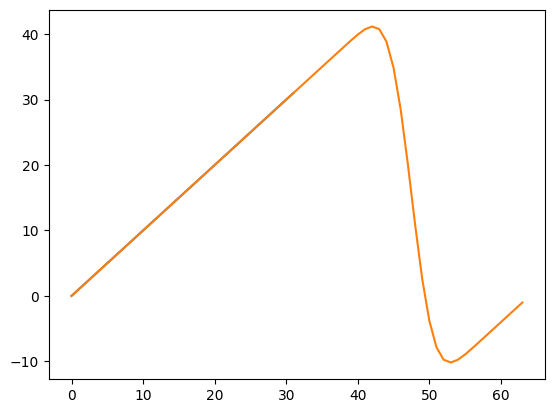

In [153]:
f = mp.matrix(32, 1)
for i in range(32): 
    f[i, 0] = i
fext = gfix.computeExtension * f

plt.plot(f)
plt.plot(np.array(fext.tolist(), dtype=complex))

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


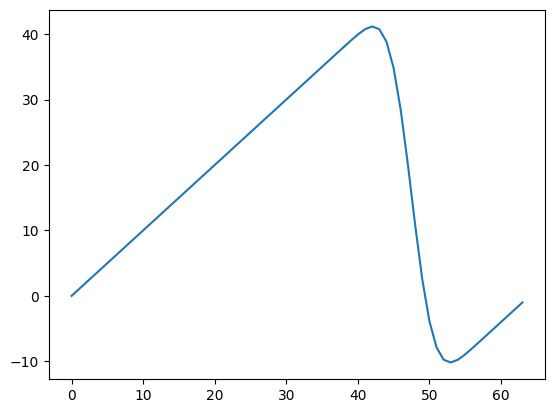

In [112]:
fhr = mp.matrix(32, 1)
for i in range(32): 
    fhr[i, 0] = i
flhr = mp.matrix(nDelta, 1)
frhr = mp.matrix(nDelta, 1)
for i in range(nDelta): 
    flhr[i, 0]  = fhr[i]
    frhr[i, 0]  = fhr[N-nDelta + i]

hrPl     = gfix.extension.Pl
hrPr     = gfix.extension.Pr
hral     = hrPl * flhr
hrar     = hrPr * frhr

nExt= 32
hrFe = mp.matrix(nExt, m)
hrFo = mp.matrix(nExt, m)
for i in range(nExt):
    for j in range(m): 
        hrFe[i, j] = gfix.extension.F[j    , nDelta + i]
        hrFo[i, j] = gfix.extension.F[j + m, nDelta + i]

hrae = ((hral + hrar)/2)
hrao = ((hrar - hral)/2)
hrfe = hrFe * hrae
hrfo = hrFo * hrao
fmatch = hrfe + hrfo

fext3 = mp.matrix(64, 1)
for i in range(32): 
    fext3[i] = fhr[i, 0]
for i in range(32, 64): 
    fext3[i] = fmatch[i - 32, 0]
plt.plot(np.array(fext3.tolist(),dtype=complex))

/home/calab912/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow
  fig.canvas.print_figure(bytes_io, **kw)


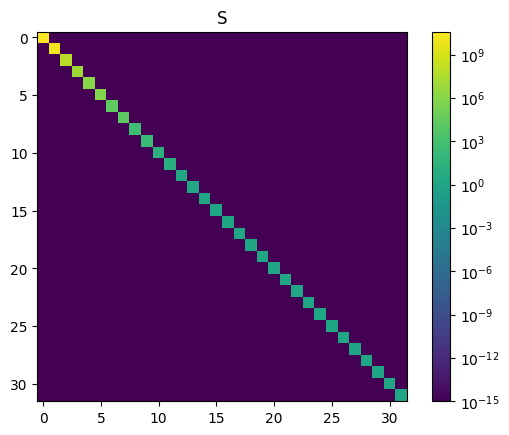

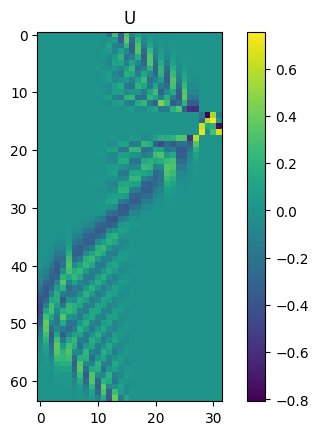

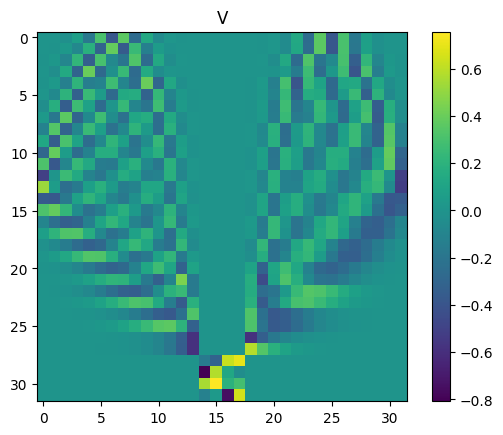

<Figure size 640x480 with 0 Axes>

In [275]:

from matplotlib import colors
plt.title("S") 
plt.imshow(np.abs(npS) + 1e-15, norm=colors.LogNorm())
plt.colorbar()
plt.show()
plt.savefig("/home/calab912/Downloads/S.png")
plt.title("U") 
plt.imshow(npU)
plt.colorbar()
plt.show()
plt.savefig("/home/calab912/Downloads/U.png")
plt.title("V")
plt.imshow(npV)
plt.colorbar()
plt.show()
plt.savefig("/home/calab912/Downloads/V.png")

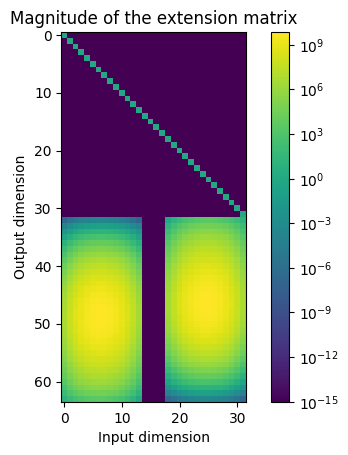

In [272]:
plt.title("Magnitude of the extension matrix")
plt.imshow(np.abs(Ex2) + 1e-15, norm=colors.LogNorm())
plt.xlabel("Input dimension") 
plt.ylabel("Output dimension") 
plt.colorbar()

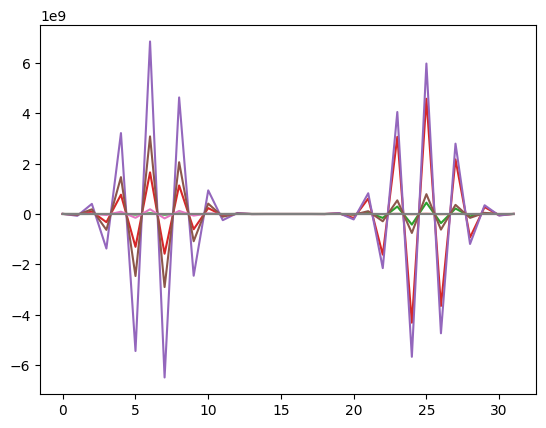

In [268]:
for i in range(32, 64, 4): 
    plt.plot(Ex2[i, :])

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


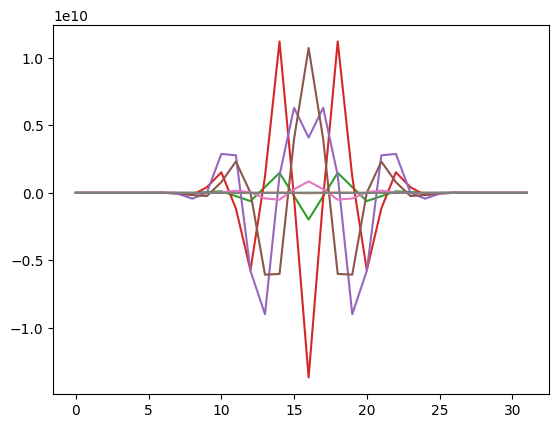

In [269]:
for i in range(32, 64, 4): 
    plt.plot(scipy.fft.fft(Ex2[i, :]))

[                                                                            0.0]
[                                                                            1.0]
[                                                                            2.0]
[                                                                            3.0]
[                                                                            4.0]
[                                                                            5.0]
[                                                                            6.0]
[                                                                            7.0]
[                                                                            8.0]
[                                                                            9.0]
[                                                                           10.0]
[                                                                           11.0]
[               

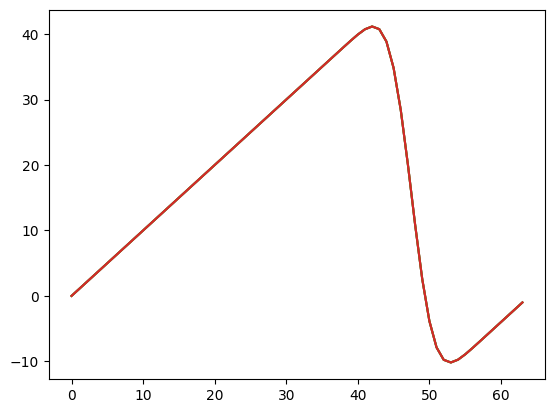

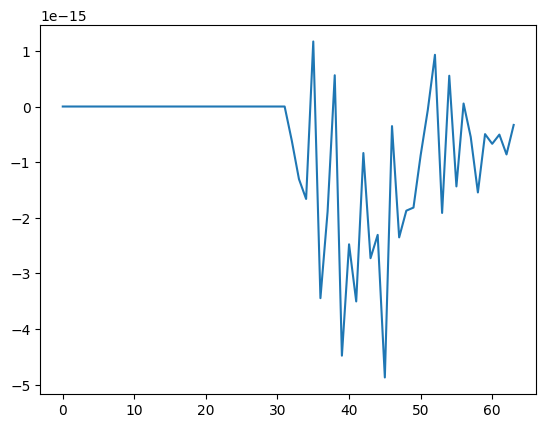

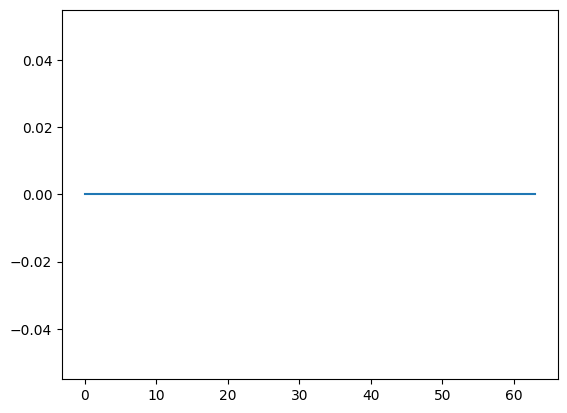

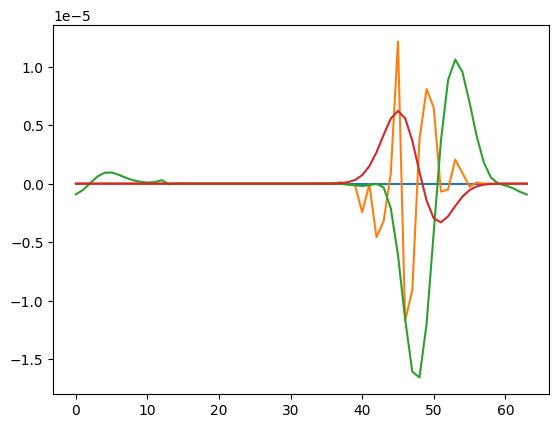

In [254]:
N = 32
nDelta = 14
nD = nDelta 
nd = 34 
m      = nDelta 
Gamma  = 150
g      = 63
F = np.fromfile(f"/home/calab912/Documents/SpectralInterpolation/gamer/tool/table_maker/GramFE/extension_tables/F_nD={nD}_nd={nd}_m={nD}_g={g}_Gamma={Gamma}.bin", dtype=np.float128).reshape(nD * 2, 2 * nD + 2 * nd - 4) 
Pl = np.fromfile(f"/home/calab912/Documents/SpectralInterpolation/gamer/tool/table_maker/GramFE/polynomial_tables/Pleft_m={nD}_nD={nD}.bin", dtype=np.float128).reshape( nD, nD)
Pr = np.fromfile(f"/home/calab912/Documents/SpectralInterpolation/gamer/tool/table_maker/GramFE/polynomial_tables/Pright_m={nD}_nD={nD}.bin", dtype=np.float128).reshape(nD, nD)
Ex = np.fromfile(f"/home/calab912/Documents/SpectralInterpolation/gamer/tool/table_maker/GramFE/extension_tables/N={N}_nD={nD}_nd={nd}_m={nD}_g={g}_Gamma={Gamma}.bin", dtype=np.float128).reshape(64, 32)

f = mp.matrix(32, 1)
for i in range(32): 
    f[i, 0] = i

with workdps(32): 
    fext = gfix.computeExtension * f
    print(fext)
print(gfix.computeExtension.rows, gfix.computeExtension.cols)
Ex2 =np.real((np.array(gfix.computeExtension.tolist(), dtype=complex)).reshape(64, 32))
#F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
#Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD)
#Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD)
#Ex2[np.abs(Ex2)<1e-64] = 0
print(Ex2)
Fe = F[:nD, nDelta:nDelta+nd -2]
Fo = F[nD:, nDelta:nDelta+nd -2]

f = np.arange(32, dtype=np.float128)
psi = f
f   = psi 
fl  = psi[:nDelta]
fr  = psi[-nDelta:]

al     = Pl.astype(np.float128) @ fl.astype(np.float128) 
ar     = Pr.astype(np.float128) @ fr.astype(np.float128) 
al[np.abs(al)<1e-14] = 0
ar[np.abs(ar)<1e-14] = 0
ae     = (al + ar)/2
ao     = (ar - al)/2
fe     = ae @ Fe 
fo     = ao @ Fo 

#al[self.proj+1:] = 0
#ar[self.proj+1:] = 0
fpl    = al @ Pl 
fpr    = ar @ Pr
fmatch = fe + fo 

fext2 = np.concatenate([f, fmatch])

f1 = np.real(np.array(fext.tolist(), dtype=np.complex256)).flatten()
f2 = np.real(fext2)
f3 = np.real(np.array(fext3.tolist(), dtype=np.complex256)).flatten()
f4 = Ex2 @ f 

def toNumpy(M): 
    return np.array(M.tolist(), dtype=np.float128).reshape((M.rows, M.cols))
npQ = toNumpy(Q) 
npR = toNumpy(R) 
f5 = npQ @  npR @ f

npS = toNumpy(mp.diag(S))
npV = toNumpy(V) 
npU = toNumpy(U)
f6 = npU @ (npS @ (npV @ f))

print(f1.shape, f2.shape)
plt.plot(f1)
plt.plot(f2)
plt.plot(f3)
plt.plot(f4)
plt.show()
plt.plot(f1-f2)
plt.show()
plt.plot(f1-f3)
plt.show()
plt.plot(f2-f3)
plt.plot(f1-f4)
plt.plot(f1-f5)
plt.plot(f1-f6)
plt.show()

In [182]:
def compare(nparr, mparr): 
    return nparr - np.array(mparr.tolist(), dtype=nparr.dtype).flatten()

In [185]:
gfix.computeExtension.rows, gfix.computeExtension.cols, Ex2.shape

(64, 32, (64, 32))

In [221]:
gfix.computeExtension

matrix(
[['1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'

In [229]:
mp.dps = 64
npext = np.zeros((64, 32), dtype=np.longdouble)
reM   = gfix.computeExtension.apply(mp.re)
for i in range(64): 
    for j in range(32):
        npext[i][j] = (reM[i, j] / 10000)

In [236]:
A = reM 

In [242]:
S

matrix(
[['38437291411.44758260910920673037712618653441468044563784367558116'],
 ['10467245863.53168321417301382636127262822928267076333266321508701'],
 ['61373023.48714385668683107457836064229707053774567032849685455819'],
 ['8699128.969866412694452841323139964575141603740483137646700044041'],
 ['1112404.445463683321296643730143167839552938250128935380941174146'],
 ['765747.0780390628754289683247926823918088434944850493540263314479'],
 ['16240.07127391532411325092262533142364352740582440600890007004254'],
 ['13485.41194538967866210760728452511401179173329910549333256286519'],
 ['446.5913253583600963613581901215853739704614471237690106809125589'],
 ['293.8473288636336063155690746213543778876986618207999849625390333'],
 ['21.77861970359191824596313888938310426071846227058871428415893081'],
 ['14.84415665677178462509944638281626658569975399295871092100296074'],
 ['2.398584978843287716277667492618820521209576787218336382510508288'],
 ['1.911372487552173409134303854362610249012731354084215

In [243]:
Q, R = mp.qr(A)

In [245]:
Q * R - A

matrix(
[['0.0', '1.35043987593034871244121664656971592134873226919252207744058848e-67', '-1.344737525418396494906121632344460098774045547727850105602525072e-66', '-5.309581976316226192872071130927330105387620909218537701509435768e-67', '-6.865189893839667356283010745702433868872181064609974914791552959e-66', '-1.740415504005831575065889604435055202140514884597647065118550957e-66', '-7.854368046561849213930574072592779272348747635046468342971394443e-66', '1.32733389452795130143897904336855353723928738857282945287158293e-65', '-1.627834431605987335196794685035876677801630352799037850970002039e-65', '1.029027213054747327850038222595007690819631289918422833849082479e-65', '-1.977934367149319968439131680223259837100811929534028559347012473e-66', '-3.114481927431731527122332570381516487946437829914429173937865921e-68', '3.871170219235186295994776814820917187217595649656764691945819657e-68', '2.43414399799391739566173080140856385587621437361214439481649157e-69', '0.0', '0.0', '0.0', '0.0', '

In [237]:
U, S, V = mp.svd_r(A)

npU = np.array(U.tolist)
print(mp.chop(A - U * mp.diag(S) * V))

[-1.275838002109642972511961483740687965555725149216329713746994229e-56   4.876850854582262932885271886749954671450252621144796744373723795e-57  -2.421874879076811025703525144429633947033602934657287973268071621e-56   4.711634349864210287440287318185602684119395681362227317642320776e-57  -1.192396209344896782404775747184969542327351039732034696830637943e-55   3.520050013527598818915757980434818485455929387188309838101193542e-55  -3.451092665160577649037481765270421670123671006048635989884144876e-55    -4.4655282550830531399106727661687393560103031823968853760007351e-55   -2.20837740431244715621156352112064839697273401341807407488135936e-55  -1.544612058355904559132350854457855816975325962351644833799211465e-56   2.377058765970920170406484889358280643608353495329263345347644971e-56  -6.794628472260899548790690003909295051363117713674269682981613921e-57   3.377952535529067301823905709458627466292288270657634395069823176e-57  -6.591532405926666526220189320951455320347752601443065785351456

In [233]:
sum = 0
for j in range(32): 
    sum += reM[i, j]
    
sum

mpf('0.9999999999999999999999999999999999999999999999999999999906461541156')

In [234]:
sum = 0
for j in range(32): 
    sum += npext[i, j]
    
sum

0.00010000002409071839793

In [241]:
np.linalg.cond(npext.astype(float))

38437293741.52261

In [230]:
i = 44

R1 = 0
for j in range(32): 
    R1 += j * reM[i, j]



R2 = 0
for j in range(32): 
    R2 += j * npext[i, j]

In [231]:
R1 - R2*10000

mpf('-0.000004053550079231880529815330387027298480344876180004420789112665398845')

In [223]:
for i in range(64): 
    for j in range(32):
        diff = np.abs(reM[i, j] - npext[i, j])
        if diff > 1e-7:
            print(i, j)
            print(reM[i, j])
            print(npext[i, j])
            print(diff)

42 24
-1723262528.867832533499694908472427410449398267739628970778022952
-1723262528.8678324223
0.0000001112432251819099274104493982677396289707780229522086962778796027
43 26
-2467731981.353721315973291838790717922007649832288538510437429557
-2467731981.3537211418
0.0000001741581062919157179220076498322885385104374295565441479780661955
44 5
-1306761550.249177103631835273809764434010644919208371655161691263
-1306761550.2491772175
0.000000113851685234002735565989355080791628344838308737146063847155043
44 24
-4324608524.8157097829811117395263524687807442001565918172079294
-4324608524.8157100677
0.0000002847679116979736475312192557998434081827920705998463047016527927
44 25
4584986406.341276042194689414370059368994467155929323496026636166
4584986406.341276169
0.0000001266285527731299406310055328440706765039733638340546387761525646
44 26
-3658758885.458700877943700886297679793285795333641374285422936831
-3658758885.458700657
0.00000022105283174567267979328579533364137428542293683116759079053

In [192]:
for i in range(64): 
    for j in range(32):
        diff = np.abs(np.real(gfix.computeExtension[i, j]) - np.real((np.matrix(gfix.computeExtension.tolist(), dtype=complex))[i, j]))
        if diff > 1e-15:
            print(diff)

0.0000000000000036156748096626587645143993079084490849606082641237455891709301804295978071246326249190177414280616610315251589794930648592172309
0.000000000000026124167121510153703474377363630450657308561002128537380884638232596290135889589482443239173989037964239377727325795488685999415
0.000000000000021326448927010581352301344119550245085644538365419303108244759921737694175879313968995663443658648252810395601864854583555239183
0.00000000000003121739145538723120593275702979723935198336871541547428535075249683721744792419440484863106493702802086685589222001800225191276
0.000000000000012569630552618013784595014357026171451617014588702384697635980850175283482316646796339030416198545820204778635918356372922742318
0.000000000000025974885568245001313687762817853022791998478235887724009555342447994622168039749927203658912642521154659368247394711549484125371
0.00000000000006508510859814391467395121287242453074353179162879906012266177836412161615299996153655039576787855196212106135217631822904

In [110]:
compare(Pl.flatten(), hrPl), compare(Pr.flatten(), hrPr)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float128),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.

In [114]:
compare(f, fhr)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float128)

In [115]:
compare(fl, flhr), compare(fr, frhr)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float128),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float128))

In [138]:
Pl.astype(np.complex256) @ fl.astype(np.complex256), hrPl * flhr

(array([ 2.43207730e+01+0.j,  1.50831031e+01+0.j,  0.00000000e+00+0.j,
         4.85722573e-17+0.j, -9.02056208e-17+0.j, -2.35922393e-16+0.j,
         4.96130914e-16+0.j,  5.13478149e-16+0.j,  3.60822483e-16+0.j,
        -2.22044605e-16+0.j,  4.73579509e-16+0.j, -6.41847686e-17+0.j,
         3.04443970e-16+0.j,  8.18572640e-18+0.j], dtype=complex256),
 matrix(
 [['24.320773014030619006294366760057570461414128750561725150974345537580228515995103681849264318763467214756442076730387854045792675'],
  ['15.08310312899835608625838221229693251274611537635525968470693082247482522196084639541541899732866997238856397121341974105347161'],
  ['1.7546266006065470536481327406073083857474025682841769941708042015918144521764705161617090059218626482372824050764788393470495119e-127'],
  ['-1.0631901110509814790900286336521622215077336785160777506045754235904357714716779080843161224731574212070871263853700017554334183e-126'],
  ['5.6276988323153974487897330423949204982746213411848359245205932293089978947

In [129]:
compare(Pl @ fl, hrPl * flhr), compare(Pr @ fr, hrPr * frhr)

(array([ 2.55351296e-015, -6.93889390e-018, -1.75462660e-127,
         4.85722573e-017, -9.02056208e-017, -2.35922393e-016,
         4.96130914e-016,  5.13478149e-016,  3.60822483e-016,
        -2.22044605e-016,  4.73579509e-016, -6.41847686e-017,
         3.04443970e-016,  8.18572640e-018], dtype=float128),
 array([ 3.88578059e-015, -6.93889390e-018, -2.88251068e-126,
         4.85722573e-017, -3.40005801e-016, -2.35922393e-016,
         1.87003191e-015,  5.13478149e-016,  1.36002321e-015,
        -2.22044605e-016,  1.78503046e-015, -6.41847686e-017,
         1.14751958e-015,  8.07730619e-018], dtype=float128))

In [141]:


compare(al, hral), compare(ar, hrar)

(array([ 2.55351296e-015, -6.93889390e-018, -1.75462660e-127,
         1.06319011e-126, -5.62769883e-127, -3.47670334e-126,
        -2.89545071e-124,  4.76680536e-123, -3.95051586e-122,
         2.80034494e-121, -3.07099523e-120,  5.05966857e-119,
        -7.61110297e-118,  8.62951574e-117], dtype=float128),
 array([ 3.88578059e-015, -6.93889390e-018, -2.88251068e-126,
         1.23285781e-124, -3.10573426e-123,  1.00580228e-121,
        -3.86347265e-120,  9.54791659e-119, -1.50350663e-117,
         2.85433716e-116, -1.80849618e-114,  9.76874178e-113,
        -8.69597875e-112, -5.67202793e-109], dtype=float128))

In [97]:
compare(ae, hrae), compare(ao, hrao)

(array([ 1.44328993e-015, -6.93889390e-018, -1.52898667e-126,
         4.85722573e-017, -2.15105711e-016, -2.35922393e-016,
         1.18308141e-015,  5.13478149e-016,  8.60422844e-016,
        -2.22044605e-016,  1.12930498e-015, -6.41847686e-017,
         7.25981775e-016,  8.13151629e-018], dtype=float128),
 array([ 2.44249065e-015,  2.30824465e-128, -1.35352401e-126,
         6.11112957e-125, -1.24900090e-016,  5.02918526e-122,
         6.86950496e-016,  4.77371996e-119,  4.99600361e-016,
         1.42715458e-116,  6.55725474e-016,  4.88436836e-113,
         4.21537805e-016, -5.42101086e-020], dtype=float128))

In [106]:
compare(Fe.astype(np.complex256).flatten(), hrFe.T), compare(Fo.astype(np.complex256).flatten(), hrFo.T)

(array([0.+1.32357435e-224j, 0.+1.52080477e-224j, 0.+1.53518648e-224j,
        0.+1.38077816e-224j, 0.+1.12690579e-224j, 0.+8.46499405e-225j,
        0.+5.01968201e-225j, 0.-3.68369490e-225j, 0.-3.42743356e-224j,
        0.-1.28569078e-223j, 0.-3.63451345e-223j, 0.-8.35398967e-223j,
        0.-1.60028970e-222j, 0.-2.58715645e-222j, 0.-3.55692880e-222j,
        0.-4.17793375e-222j, 0.-4.20239532e-222j, 0.-3.62115158e-222j,
        0.-2.66934504e-222j, 0.-1.67830644e-222j, 0.-8.96253917e-223j,
        0.-4.04857979e-223j, 0.-1.54735041e-223j, 0.-5.10544113e-224j,
        0.-1.60116574e-224j, 0.-6.32088071e-225j, 0.-4.00594861e-225j,
        0.-3.16834559e-225j, 0.-2.17706756e-225j, 0.-7.04981194e-226j,
        0.+1.14629665e-225j, 0.+3.13373170e-225j, 0.-4.83930830e-126j,
        0.-1.87956671e-123j, 0.-1.39859745e-121j, 0.-4.20979082e-120j,
        0.-6.89886671e-119j, 0.-7.18759917e-118j, 0.-5.22518275e-117j,
        0.-2.81677065e-116j, 0.-1.17433750e-115j, 0.-3.90231288e-115j,
      

In [100]:
compare(fe.astype(np.complex256), hrfe), compare(fo.astype(np.complex256), hrfo)

(array([9.99844305e-13-7.29917861e-125j, 1.10241347e-11-2.83496986e-122j,
        6.85393148e-11-2.10951895e-120j, 3.12557005e-10-6.34967090e-119j,
        1.16054842e-09-1.04056318e-117j, 3.70451903e-09-1.08411300e-116j,
        1.04843899e-08-7.88119702e-116j, 2.67517933e-08-4.24856422e-115j,
        6.19701463e-08-1.77126536e-114j, 1.30385507e-07-5.88589875e-114j,
        2.48390213e-07-1.59384612e-113j, 4.26581567e-07-3.57543684e-113j,
        6.57723151e-07-6.72612491e-113j, 9.07547516e-07-1.07059344e-112j,
        1.11830366e-06-1.45081260e-112j, 1.22920936e-06-1.68047202e-112j,
        1.20493218e-06-1.66684310e-112j, 1.05397057e-06-1.41567159e-112j,
        8.23893590e-07-1.02741126e-112j, 5.77019655e-07-6.34523976e-113j,
        3.63418264e-07-3.31340015e-113j, 2.06851049e-07-1.44956652e-113j,
        1.07007517e-07-5.24685678e-114j, 5.05805642e-08-1.54503472e-114j,
        2.19108471e-08-3.61834229e-115j, 8.68253787e-09-6.53437481e-116j,
        3.11889334e-09-8.71594117e-117

In [4]:
for N in [32, 48]: 
    for nd in [34]: 
        for nDelta in [10, 12]: 
            m      = nDelta 
            Gamma  = 150
            g      = 63
            GramFEFixedSizeExtension(N, m, nDelta, nd, Gamma, g) 

KeyboardInterrupt: 

## Create header files for GAMER

### Create GramFE_ExtensionTables.h

In [14]:

def printCMatrix(mat, name, arraysize, file):
    n, m = mat.rows, mat.cols 
    rem = mat.apply(mp.re) 
    imm = mat.apply(mp.im) 

    print(f"const static long double {name}[{arraysize}] = ", end="", file=file)
    print("{", file=file)
    for i in range(n):
        print("", end="", file=file)
        for j in range(m):
            print(f"{mp.nstr(rem[i,j], n=64)}, {mp.nstr(imm[i,j], n=64)}", end="", file=file)
            if j != m - 1:
                print(", ", end="", file=file)
        

        print("", end=",\n", file=file)  
    print("}", end=";\n", file=file)  

with open("HRExtend.h", "w") as f:
    printCMatrix(gfix.computeExtension, "GramFE_Extend", "2 * GRAMFE_FLU_NXT * FLU_NXT", file=f) 

In [3]:
nExtension=64
N = 32
ghostBoundary=8
fft           = np.fromfile(f"fft_tables/N={nExtension}.bin", dtype=np.complex256).reshape((nExtension, nExtension))
ifft          = np.fromfile(f"ifft_tables/N={nExtension}.bin", dtype=np.complex256).reshape((nExtension, nExtension))[ghostBoundary:N-ghostBoundary, :]


In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy

def printCMatrix(mat, name, arraysize, file):
    n, m = mat.shape    

    print(f"const static long double {name}[{arraysize}] = ", end="", file=file)
    print("{", file=file)
    for i in range(n):
        print("", end="", file=file)
        for j in range(m):
            print(f"{np.real(mat[i,j]):10.32e}, {np.imag(mat[i,j]):10.32e}", end="", file=file)
            if j != m - 1:
                print(", ", end="", file=file)
        

        print("", end=",\n", file=file)  
    print("}", end=";\n", file=file)  

def printRMatrix(mat, name, arraysize1, arraysize2, file):
    n, m = mat.shape    

    print(f"GPU_DEVICE_VARIABLE const static gramfe_float  {name}[{arraysize1}][{arraysize2}] = ", end="", file=file)
    print("{", file=file)
    for i in range(n):
        print("{", end="", file=file)
        for j in range(m):
            print(f"{mat[i,j]:10.32f}", end="", file=file)
            if j != m - 1:
                print(", ", end="", file=file)
        

        print("}", end=",\n", file=file)  
    print("}", end=";\n", file=file)  

with open("GramFE_ExtensionTables.h", "w") as f:

    print(
    r"""

# ifndef __GRAM_EXTENSION_TABLES_H__
# define __GRAM_EXTENSION_TABLES_H__

# include "CUFLU.h"
# include "Macro.h"

# if ( MODEL == ELBDM && WAVE_SCHEME == WAVE_GRAMFE )


// **********************************************************************************************************
// ** Precomputed (at least) double precision values of Gram polynomials and their periodic Fourier        **
// ** extensions as used in the Gram-Fourier extension algorithm.                                          **
// ** For FFT algorithm:                                                                                   **
// ** GRAMFE_NDELTA = 14                                                                                   **
// ** GRAMFE_ND     = 24, 26, 28, 30, 32                                                                   **
// ** GRAMFE_ORDER  = GRAMFE_ORDER                                                                         **
// **                                                                                                      **
// ** For matrix multiplication algorithm:                                                                 **
// ** PATCH_SIZE    = 8, 16                                                                                **
// ** GRAMFE_NDELTA = 14, 16, 32                                                                           **
// ** GRAMFE_ND     = 32                                                                                   **
// ** GRAMFE_ORDER  = 14                                                                                   **
// **********************************************************************************************************

# if ( GRAMFE_SCHEME == GRAMFE_MATMUL )

// precision of computation of time evolution operator, should be double or higher
#define GRAMFE_MM

// precision of matrix multiplication, same as FLOAT8
#ifdef FLOAT8
#define GRAMFE_EV
#endif

""", file=f)



    N             = 32 
    g             = 63 
    Gamma         = 150 
    first         = 1
    nD            = 14 
    nd            = 34
    ghostBoundary = 8 

    first         = 1

    for N in [32]: 
        for nd in [34]: 
            nExtension    = N + nd - 2 
            for nDelta in [14]: 
                for m in [14]:
                    nD = nDelta
                    #extendandfft  = np.fromfile(f"extension_tables/FFT_N={N}_nD={nD}_nd={nd}_m={m}_g={g}_Gamma={Gamma}.bin", dtype=np.complex256).reshape((nExtension, N))
                    extend        = np.fromfile(f"extension_tables/N={N}_nD={nD}_nd={nd}_m={m}_g={g}_Gamma={Gamma}.bin", dtype=np.float128).reshape(nExtension, N)
                    fft           = np.fromfile(f"fft_tables/N={nExtension}.bin", dtype=np.complex256).reshape((nExtension, nExtension))
                    ifft          = np.fromfile(f"ifft_tables/N={nExtension}.bin", dtype=np.complex256).reshape((nExtension, nExtension))[ghostBoundary:N-ghostBoundary, :]

                    if first: 
                        print(f"\n# if (PATCH_SIZE == {int(N/2)  - 8} && GRAMFE_ND == {nd - 2} && GRAMFE_NDELTA == {nD} && GRAMFE_ORDER == {m})\n", file=f)
                        first = 0
                    else:
                        print(f"\n# elif (PATCH_SIZE == {int(N/2)  - 8} && GRAMFE_ND == {nd - 2} && GRAMFE_NDELTA == {nD} && GRAMFE_ORDER == {m})\n", file=f)

                    printCMatrix( fft, "GramFE_FFT", "2 * GRAMFE_FLU_NXT * GRAMFE_FLU_NXT", file=f)
                    printCMatrix(ifft, "GramFE_IFFT", "2 * GRAMFE_FLU_NXT * GRAMFE_FLU_NXT", file=f)
                    printCMatrix(extend, "GramFE_Extend", "2 * GRAMFE_FLU_NXT * FLU_NXT", file=f)
    print(
    r"""# else
# error: ERROR : Unsupported fixed size Gram extension
# endif

#elif ( GRAMFE_SCHEME == GRAMFE_FFT )
""", file=f) 


    g     = 63 
    Gamma = 150 
    first = 1
    for nD in [14]:
        for nd in [26, 28, 30, 32, 34]:


            F = np.fromfile(f"extension_tables/F_nD={nD}_nd={nd}_m={m}_g={g}_Gamma={Gamma}.bin", dtype=np.float128).reshape(nD * 2, 2 * nD + 2 * nd - 4) 
            Fe = F[:nD, nD:nD + nd - 2]
            Fo = F[nD:, nD:nD + nd - 2]


            if first: 
                print(f"\n# if (GRAMFE_NDELTA == {nD} && GRAMFE_ND == {nd - 2})\n", file=f)
                first = 0
            else:
                print(f"\n# elif (GRAMFE_NDELTA == {nD} && GRAMFE_ND == {nd - 2})\n", file=f)


            printRMatrix(Fe, "Fe", "GRAMFE_NDELTA", "GRAMFE_ND", file=f)
            print("", file=f)
            printRMatrix(Fo, "Fo", "GRAMFE_NDELTA", "GRAMFE_ND", file=f)
            print("", file=f)

    print(
    r"""# else
# error: ERROR : Unsupported Gram Fourier Extension
# endif""", file=f)

    first = 1

    for nD in [14]:
        m  = nD 
        Pl = np.fromfile(f"polynomial_tables/Pleft_m={m}_nD={nD}.bin", dtype=np.float128).reshape(m, nD) 
        Pr = np.fromfile(f"polynomial_tables/Pright_m={m}_nD={nD}.bin", dtype=np.float128).reshape(m, nD) 

        if first: 
            print(f"\n# if (GRAMFE_NDELTA == {nD} && GRAMFE_ORDER == {m})\n", file=f)
            first = 0
        else:
            print(f"\n# elif (GRAMFE_NDELTA == {nD} && GRAMFE_ORDER == {m})\n", file=f)

        printRMatrix(Pl, "Pl", "GRAMFE_ORDER", "GRAMFE_NDELTA", file=f)
        print("", file=f)
        printRMatrix(Pr, "Pr", "GRAMFE_ORDER", "GRAMFE_NDELTA", file=f)
    print(
    r"""# else
# error: ERROR : Unsupported Gram Polynomial
# endif""", file=f) 




    print(
    r"""
# endif // # GRAMFE_SCHEME
# endif // # if ( WAVE_SCHEME == WAVE_GRAMFE )
# endif // # ifndef __GRAM_EXTENSION_TABLES_H__""", file=f)

### Create GramInterpolationTables.h

In [16]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy


def printCMatrix(mat, name, f):
    n, m = mat.shape    

    print(f"\t\t\t\treturn new double[{n*m}]", file=f)
    print("\t\t\t\t\t{", file=f)
    for i in range(n):
        print("\t\t\t\t\t", end="", file=f)
        for j in range(m):
            print(f"{mat[i,j]:10.17f}", end="", file=f)
            if j != m - 1:
                print(", ", end="", file=f)
        

        if i != n - 1:
            print(",", file=f)  
    print("\n\t\t\t\t\t}", end=";\n", file=f)  

with open("GramInterpolationTables.h", "w") as f:

    print(
    r"""
    # ifndef __GRAM_INTERPOLATION_TABLES_H__
    # define __GRAM_INTERPOLATION_TABLES_H__


    # include "CUFLU.h"
    # include "Macro.h"

    # ifdef SUPPORT_SPECTRAL_INTERPOLATION 

    // **********************************************************************************************************
    // ** Precomputed (at least) double precision values of interpolation tables based on Gram-Fourier         **
    // ** extensions for fixed input sizes N.                                                                  **
    // ** SUPPORTED N = {3, 64}                                                                                **
    // **********************************************************************************************************

    double* GramFE_GetSpectralInterpolationTable(size_t N) 
    {
        switch(N) {""", file=f)


    for N in range(3, 65): 

            F = np.fromfile(f"interpolation_tables/N={N}.bin", dtype=float).reshape(2 * (N-2), N) 
            print(f"\t\t\tcase {N}:", file=f)
            printCMatrix(F, f"GFEI_N{N}", f=f)
            print( "\t\t\t\tbreak;", file=f)
            
    print(
    r"""
        default: 
            Aux_Error(ERROR_INFO, "Unsupported size of spectral interpolation table!!\n");
            return NULL;
        }
    }

    # endif // # ifdef SUPPORT_SPECTRAL_INTERPOLATION 
    # endif // # ifndef __GRAM_INTERPOLATION_TABLES_H__""", file=f)